### Пример применения многозернистого сканирования 

Многозернистое сканирование (Multigrained scanning) - это алгоритм, который применяется для обработки изображений. Его описание можно найти в этой [статье](https://arxiv.org/pdf/1702.08835v1.pdf). Утверждается, что Глубокий лес с многозернистым сканированием может быть сравним по качеству предсказаний со сверточными нейросетями.

In [1]:
from bosk.painter.graphviz import GraphvizPainter
from bosk.executor.recursive import RecursiveExecutor
from bosk.stages import Stage
from bosk.block.zoo.multi_grained_scanning import MultiGrainedScanning2DBlock
from bosk.pipeline.builder.functional import FunctionalPipelineBuilder
from sklearn.datasets import load_digits
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
import numpy as np
from IPython.display import Image

In [2]:
random_state = 42
n_estimators = 7
EXEC_CLS = RecursiveExecutor

def get_image_dataset():
    digits = load_digits()
    all_X = digits.data
    all_y = digits.target
    train_X, test_X, train_y, test_y = train_test_split(
        all_X, all_y, test_size=0.2, random_state=random_state)
    return train_X, test_X, train_y, test_y

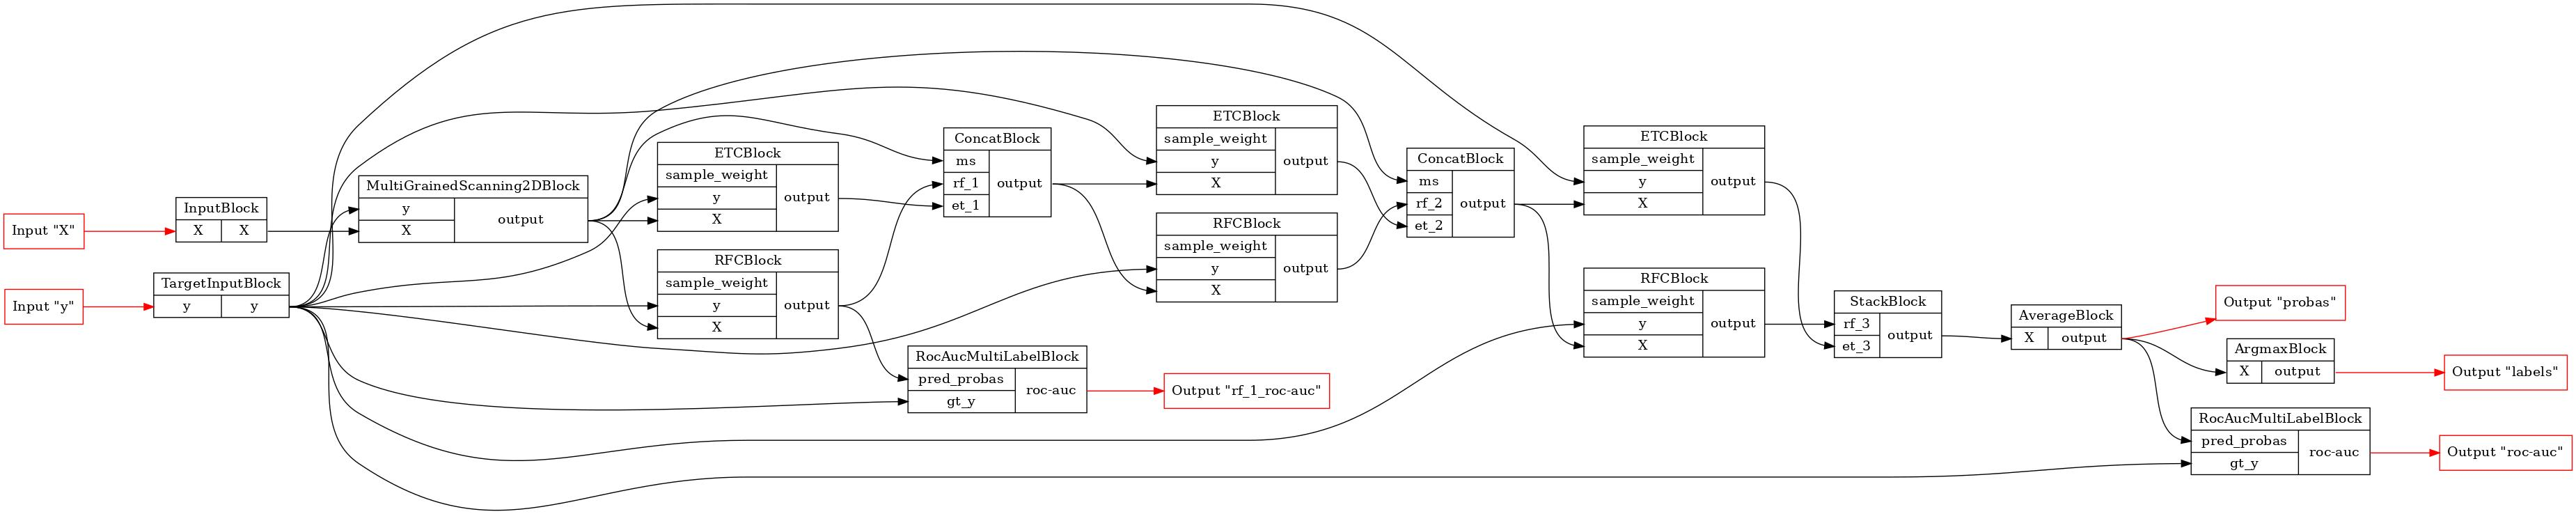

In [3]:
b = FunctionalPipelineBuilder()
X, y = b.Input()(), b.TargetInput()()
ms = b.new(MultiGrainedScanning2DBlock, models=(
    RandomForestClassifier(n_estimators=n_estimators),
    ExtraTreesClassifier(n_estimators=n_estimators)),
    window_size=5, stride=1, shape_sample=[8, 8])(X=X, y=y)
rf_1 = b.RFC()(X=ms, y=y)
et_1 = b.ETC()(X=ms, y=y)
concat_1 = b.Concat(['ms', 'rf_1', 'et_1'])(ms=ms, rf_1=rf_1, et_1=et_1)
rf_2 = b.RFC()(X=concat_1, y=y)
et_2 = b.ETC()(X=concat_1, y=y)
concat_2 = b.Concat(['ms', 'rf_2', 'et_2'])(ms=ms, rf_2=rf_2, et_2=et_2)
rf_3 = b.RFC()(X=concat_2, y=y)
et_3 = b.ETC()(X=concat_2, y=y)
stack_3 = b.Stack(['rf_3', 'et_3'], axis=1)(rf_3=rf_3, et_3=et_3)
average_3 = b.Average(axis=1)(X=stack_3)
argmax_3 = b.Argmax(axis=1)(X=average_3)
#
rf_1_roc_auc = b.RocAucMultiLabel()(gt_y=y, pred_probas=rf_1)
roc_auc = b.RocAucMultiLabel()(gt_y=y, pred_probas=average_3)
pipeline = b.build({'X': X, 'y': y},
                   {'probas': average_3, 'rf_1_roc-auc': rf_1_roc_auc,
                    'roc-auc': roc_auc, 'labels': argmax_3}
                   )
pipeline.set_random_state(random_state)
# изобразим наш конвейер
GraphvizPainter(figure_dpi=100).from_pipeline(pipeline).render('deep_forest.jpeg')
display(Image(filename='deep_forest.jpeg'))

In [4]:
# выполним конвейер
fit_executor = EXEC_CLS(
    pipeline,
    stage=Stage.FIT,
    inputs=['X', 'y'],
    outputs=['probas', 'rf_1_roc-auc', 'roc-auc'],
)
transform_executor = EXEC_CLS(
    pipeline,
    stage=Stage.TRANSFORM,
    inputs=['X'],
    outputs=['probas', 'labels']
)
train_X, test_X, train_y, test_y = get_image_dataset()
fit_result = fit_executor({'X': train_X, 'y': train_y}).numpy()
train_result = transform_executor({'X': train_X}).numpy()
print("Fit probas == probas on train:", np.allclose(fit_result['probas'], train_result['probas']))
test_result = transform_executor({'X': test_X}).numpy()
print("Train ROC-AUC:", roc_auc_score(train_y, train_result['probas'], multi_class="ovr"))
print(
    "Train ROC-AUC calculated by fit_executor:",
    fit_result['roc-auc']
)
print(
    "Train ROC-AUC for RF_1:",
    fit_result['rf_1_roc-auc']
)
print("Test ROC-AUC:", roc_auc_score(test_y, test_result['probas'], multi_class="ovr"))

Fit probas == probas on train: True
Train ROC-AUC: 1.0
Train ROC-AUC calculated by fit_executor: 1.0
Train ROC-AUC for RF_1: 1.0
Test ROC-AUC: 0.998348204661033
